In [2]:
# %pip install opencv-python
# %pip install --upgrade numpy

In [3]:
# utility libraries
import numpy as np
import cv2
import sys
# import preprocessing module
sys.path.append('../')
from Preprocessing import preprocessing as pp

c:\Users\Ahmed\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def extract_roi(edge_image, image):
  """
  Extracts the region of interest (ROI) from an edge-filtered image.

  Args:
      edge_image: A grayscale image with edges detected.

  Returns:
      A list of tuples, where each tuple contains the following information for an ROI:
          - (x_min, y_min): Coordinates of the top-left corner.
          - (x_max, y_max): Coordinates of the bottom-right corner.
          - normalized_signature: Normalized signature of the ROI.
          - shape_type: Type of shape detected (e.g., "circle").
  """

  # Find contours in the edge image
  # mode: cv2.RETR_EXTERNAL retrieves only the extreme outer contours (boundries) and ignore nested inside contours

  # When you detect contours in an image, each contour is a list of points that form the boundary of the object. However,
  # not all of these points are always necessary to accurately describe the shape. 
  # `cv2.CHAIN_APPROX_SIMPLE` is an algorithm that reduces the number of points in the contour. It removes all redundant 
  # points and compresses the contour, thereby saving memory.
  # It does this by storing only the end points of the horizontal, vertical, and diagonal line segments that make up the contour. 

  # contours: list of contours where each contour is a Numpy array of (x, y) coordinates of boundary points of the object
  contours, hierarchy = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  # List to store extracted ROIs
  extracted_rois = []

  # Minimum area threshold to avoid small objects and retrieve only potential ROIs
  min_area = 100

  # Iterate through each contour
  for contour in contours:
    # Calculate area of the contour
    area = cv2.contourArea(contour)

    # Skip small contours
    if area < min_area:
      continue

    # Gets the smallest possible circle that encloses the contour with its centroid and radius
    centroid, radius = cv2.minEnclosingCircle(contour)

    # Get bounding rectangle of the contour
    # x, y: Coordinates of the top-left corner
    # w, h: Width and height of the rectangle
    x, y, w, h = cv2.boundingRect(contour)

    # Calculate the area of the enclosing circle
    circle_area = np.pi * (radius ** 2)

    # add the contour to the list of circle contours
    if  np.isclose(area, circle_area, rtol=0.3):  # 30% tolerance
        img_copy = image.copy()
        # Create an empty mask
        mask = np.zeros_like(img_copy, dtype=np.uint8)
        # Draw the contour on the mask
        cv2.drawContours(mask, [contour], 0, (255, 255, 255), thickness=cv2.FILLED)
        # Invert the mask (to keep the area inside the contour)
        mask_inv = cv2.bitwise_not(mask)
        # Set all areas outside the contour to white
        result = cv2.bitwise_and(img_copy, mask)
        result += mask_inv
        # Use the bounding rectangle coordinates to create the sub-image
        sub_image = result[y:y+h, x:x+w]

        # Create the Gaussian blur
        gauss = cv2.GaussianBlur(sub_image, (9,9), 10.0)
        # Create the unsharp image by subtracting the Gaussian blur
        unsharp_image = cv2.addWeighted(sub_image, 1.5, gauss, -0.5, 0, sub_image)

        # Store extracted ROI information
        extracted_rois.append(unsharp_image)

  # Return the list of extracted ROIs
  return extracted_rois

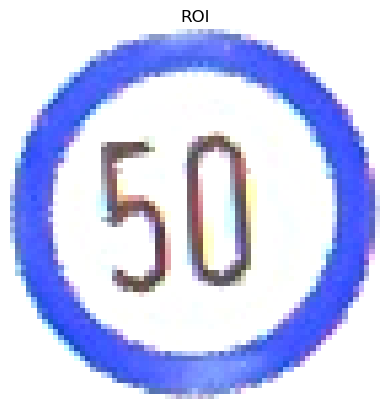

In [6]:
'''
Testing
'''
# Load the image
image = cv2.imread("../dataset/testcase5.jpg")

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply edge detection
edge_image = cv2.Canny(gray_image, 50, 150)

# pp.show_images([gray_image, edge_image], ["Grayscale Image", "Edge Image"])

# Extract ROIs
rois = extract_roi(edge_image, image.copy())

pp.show_images(rois, ["ROI"])